## Introduction
This notebook delivers a fully reproducible workflow for the Slide‑Rail Acoustic‑Anomaly Detection laboratory exercise described in the AML 2025 challenge PDF. Leveraging reference implementations from the public repositories `wilkinghoff/DCASE2023_task2` and `DCASE-REPO`, it demonstrates data preparation, model training, and evaluation in a structured manner. Each subsequent section begins with a concise, three‑sentence academic exposition to clarify its methodological role.

## Environment & Dependency Setup
This section installs the minimal set of Python libraries required for signal processing, model construction, and evaluation, ensuring version consistency with the reference GitHub repositories. Reproducibility is promoted by pinning the versions of core packages such as Librosa and PyTorch. If the environment already satisfies these dependencies, the installation commands can be safely skipped.

In [38]:
# !pip install --quiet librosa==0.10.1 torch torchvision torchaudio scikit-learn tqdm nflows==0.15.0
import warnings, random, zipfile, subprocess, os, math, json
from pathlib import Path
import numpy as np
import librosa
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')
torch.manual_seed(42); np.random.seed(42)


## Data Acquisition
Following the DCASE Task 2 protocol, the Slide‑Rail subset is retrieved from the course‑provided Kaggle dataset to guarantee alignment with the official evaluation setup. The download routine is guarded by a boolean flag to prevent redundant transfers for users who already have the data locally. All subsequent file paths are expressed relative to a configurable `DATA_DIR` variable to facilitate execution on heterogeneous platforms.

In [39]:
DOWNLOAD_DATA = False  # toggle to True on first run
DATA_DIR = Path('./dataset/dev_data/dev_data/slider')
RAW_DIR = DATA_DIR / 'raw'
RAW_DIR.mkdir(parents=True, exist_ok=True)

if DOWNLOAD_DATA:
    kaggle_zip = 'dcase-aml-slide-rail.zip'  # replace with actual filename on Kaggle
    if not (RAW_DIR / kaggle_zip).exists():
        subprocess.run(['kaggle', 'datasets', 'download', '-d', 'michiard/dcase-aml', '-p', str(RAW_DIR)])
    with zipfile.ZipFile(RAW_DIR / kaggle_zip) as zf:
        zf.extractall(RAW_DIR)
print('Data directory ready:', DATA_DIR.resolve())


Data directory ready: C:\Users\bruker\OneDrive - NTNU\8. semester\AML\AML-EURECOM-Group14\Challenge 2-Anomaly Detection\dataset\dev_data\dev_data\slider


## Acoustic Feature Extraction
Log‑Mel spectrograms are selected as the principal time–frequency representation owing to their perceptual relevance and widespread adoption in anomaly detection literature. A helper function converts raw waveforms into logarithmic Mel matrices, caching results on disk to expedite iterative experimentation. Parameters adhere to the official DCASE baselines (16 kHz sampling, 64 Mel bins) to assure comparability with benchmark studies.

In [40]:
SAMPLE_RATE = 16000
N_FFT, HOP, N_MELS = 1024, 512, 64

def extract_logmel(path, cache_dir=DATA_DIR / 'features'):
    cache_dir.mkdir(parents=True, exist_ok=True)
    cache = cache_dir / f'{path.stem}.npy'
    if cache.exists():
        return np.load(cache)
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2
    )
    logmel = librosa.power_to_db(mel).astype(np.float32)
    np.save(cache, logmel)
    return logmel


## PyTorch Dataset Wrapper
To streamline loading and batching, the `SlideRailDataset` class encapsulates on‑demand feature extraction with optional augmentation hooks. Following the one‑class paradigm, only recordings labelled as normal are passed to the training split, while a held‑out subset is reserved for validation. This explicit separation mitigates information leakage and supports robust early‑stopping strategies.

In [41]:
class SlideRailDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        feat = extract_logmel(self.files[idx])
        if self.transform:
            feat = self.transform(feat)
        return torch.from_numpy(feat).unsqueeze(0), str(self.files[idx])  # ← convert to str



# Replace the glob patterns with actual sub‑directory names in your dataset
train_files = sorted((DATA_DIR/'train').rglob('*.wav'))
val_files   = train_files[::10]
train_files = [f for f in train_files if f not in val_files]

test_files = sorted((DATA_DIR/'test').rglob('*.wav'))

## Labeling the test set

In [42]:
def label_from_filename(path):
    name = path.name.lower()
    if "normal" in name:
        return 0
    elif "anomaly" in name:
        return 1
    else:
        raise ValueError(f"Unknown label in: {path}")

test_labels = np.array([label_from_filename(f) for f in test_files])

## Convolutional Auto‑Encoder (CAE) Baseline
A lightweight CAE serves as the foundational reconstruction‑based anomaly detector, optimising mean‑squared error on normal recordings. Its convolutional encoder–decoder architecture exploits local spectral correlations while keeping parameter count modest. The validation reconstruction error distribution establishes a first‑order anomaly threshold and baseline AUC score.

In [72]:
'''
class CAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(64, latent_dim)
        )
        self.dec_fc = nn.Linear(latent_dim, 64)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3)
        )

    def forward(self, x):
        z = self.enc(x)
        z = self.dec_fc(z).view(-1, 64, 1, 1)
        return self.dec(z)
''' 

class CAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # [B, 16, 64, 313] [Batch, channels, mel bands, timeframes]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 16, 32, 156]
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # [B, 32, 32, 156]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 16, 78]
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 16, 78]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 8, 39]
        )

        self.enc_fc = nn.Sequential(
            nn.Flatten(),                                # [B, 64*8*39]
            nn.Linear(64 * 8 * 39, latent_dim)
        )

        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 39),
            nn.Unflatten(1, (64, 8, 39))                # [B, 64, 8, 39]
        )

        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 16, 78]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # [B, 16, 32, 156]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),   # [B, 1, 64, 312]
        )

        # Final 1x1 conv to pad to 313
        self.pad_to_313 = nn.ConstantPad2d((0, 1, 0, 0), 0)  # pad one column

    def forward(self, x):
        z = self.enc(x)
        z = self.enc_fc(z)
        z = self.dec_fc(z)
        recon = self.dec(z)
        recon = self.pad_to_313(recon)  # ensure final width = 313
        return recon




def cae_loss(model, x):
    recon = model(x)
    # adapt x to the shape of recon using adaptive average pooling
    #x_resized = nn.functional.adaptive_avg_pool2d(x, recon.shape[2:])
    return recon, F.mse_loss(recon, x)#x_resized)

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cae = CAE(latent_dim=256).to(device)
train_loader = DataLoader(SlideRailDataset(train_files), batch_size=16, shuffle=True)
val_loader   = DataLoader(SlideRailDataset(val_files),   batch_size=16)


## Training

In [73]:
def train_model(model, train_loader, val_loader, criterion, model_name, epochs=25, lr=1e-3, patience=8):
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best, stagnation = float('inf'), 0

    for ep in range(epochs):
        model.train(); tr = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            _, loss = criterion(model, x)
            opt.zero_grad(); loss.backward(); opt.step()
            tr += loss.item()*x.size(0)
        tr /= len(train_loader.dataset)

        # Evaluate model after each epoch
        model.eval(); vl = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                _, loss = criterion(model, x)
                vl += loss.item()*x.size(0)

        vl /= len(val_loader.dataset)
        print(f'Epoch {ep:2d} | Train mean MSE {tr:.4f} | Val mean MSE {vl:.4f}')

        if vl < best:
            best, stagnation = vl, 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            stagnation += 1
            if stagnation >= patience: #Early stopping after patience is reached (no improvements)
                print('Early stopping'); break
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))


In [74]:
train_model(cae, train_loader, val_loader, cae_loss, 'cae')

Epoch  0 | Train mean MSE 70.9221 | Val mean MSE 24.3498
Epoch  1 | Train mean MSE 22.5027 | Val mean MSE 20.6939
Epoch  2 | Train mean MSE 19.1054 | Val mean MSE 18.0754
Epoch  3 | Train mean MSE 17.6820 | Val mean MSE 17.8923
Epoch  4 | Train mean MSE 17.9457 | Val mean MSE 18.8320
Epoch  5 | Train mean MSE 16.8453 | Val mean MSE 17.7188
Epoch  6 | Train mean MSE 16.6039 | Val mean MSE 21.5321
Epoch  7 | Train mean MSE 18.4093 | Val mean MSE 16.1551
Epoch  8 | Train mean MSE 15.3246 | Val mean MSE 15.6245
Epoch  9 | Train mean MSE 14.7427 | Val mean MSE 14.8399
Epoch 10 | Train mean MSE 14.4072 | Val mean MSE 14.5723
Epoch 11 | Train mean MSE 13.9556 | Val mean MSE 14.0014
Epoch 12 | Train mean MSE 13.5587 | Val mean MSE 13.7819
Epoch 13 | Train mean MSE 13.0630 | Val mean MSE 13.2747
Epoch 14 | Train mean MSE 13.8844 | Val mean MSE 13.0731
Epoch 15 | Train mean MSE 12.4874 | Val mean MSE 12.9117
Epoch 16 | Train mean MSE 12.5995 | Val mean MSE 12.5299
Epoch 17 | Train mean MSE 12.15

## Variational Auto‑Encoder (VAE)
Replacing the deterministic bottleneck with a probabilistic latent distribution, the VAE introduces a Kullback–Leibler divergence term to regularise the encoding space. Such stochasticity often enhances generalisation, contributing a 2–3 % AUC uplift on comparable anomaly‑detection benchmarks. The implementation follows a β‑VAE variant whereby the KL contribution is tempered by a tunable scalar β.

In [99]:
'''
class VAE(CAE):
    def __init__(self, latent_dim=64):
        super().__init__(latent_dim)
        # Override encoder head
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, 64)

    def forward(self, x):
        h = self.enc(x)
        mu, logvar = self.mu(h), self.logvar(h)
        std = torch.exp(0.5*logvar)
        z = mu + std * torch.randn_like(std)
        recon = self.dec(self.dec_fc(z).view(-1, 64, 1, 1))
        return recon, mu, logvar
'''
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        
        # --- Encoder ---
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # [B, 16, 64, 313]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 16, 32, 156]
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # [B, 32, 32, 156]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 16, 78]
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 16, 78]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 8, 39]
            nn.Flatten()
        )

        self.flat_dim = 64 * 8 * 39
        self.mu = nn.Linear(self.flat_dim, latent_dim)
        self.logvar = nn.Linear(self.flat_dim, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, self.flat_dim)

        # --- Decoder ---
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 16, 78]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # [B, 16, 32, 156]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),   # [B, 1, 64, 312]
        )

        self.pad_to_313 = nn.ConstantPad2d((0, 1, 0, 0), 0)  # Final pad to get [B, 1, 64, 313]

    def forward(self, x):
        h = self.enc(x)
        mu, logvar = self.mu(h), self.logvar(h)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)

        x_hat = self.dec_fc(z).view(-1, 64, 8, 39)
        recon = self.dec(x_hat)
        recon = self.pad_to_313(recon)
        return recon, mu, logvar


beta = 0.001
vae = VAE().to(device)

def vae_loss(model, x):
    recon, mu, logvar = model(x)
    #x_resized = nn.functional.adaptive_avg_pool2d(x, recon.shape[2:])
    mse = nn.functional.mse_loss(recon, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon, mse + beta * kld


In [101]:
from pathlib import Path
file = Path("dataset/dev_data/dev_data/slider/train/normal_id_04_00000245.wav")
print(file.exists())  # Should return True or False


False


In [100]:
train_model(vae, train_loader, val_loader, vae_loss, "vae")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\dev_data\\dev_data\\slider\\train\\normal_id_04_00000245.wav'

## Normalizing Flow / Masked Auto‑Encoder (Optional)
For participants equipped with ample GPU resources, this section sketches how to integrate an explicit density estimator (Normalizing Flow) or a self‑supervised Masked Auto‑Encoder for additional performance gains. Both approaches can provide calibrated likelihoods or context‑aware reconstruction signals that complement the CAE and VAE baselines. Implementation details are referenced from the `nflows` library and the AudioMAE repository and are intentionally modular for straightforward substitution.

In [ ]:
# Placeholder: define and train a RealNVP flow or import a pre‑trained AudioMAE here
print('Implement Normalizing Flow or MAE here if hardware budget permits.')


## Deep SVDD (One‑Class Classification)
Deep Support Vector Data Description embeds inputs into a hypersphere whose radius implicitly models normal‑class variability, eschewing reconstruction altogether. Its inference cost is minimal because anomaly scoring reduces to computing Euclidean distance in latent space. A concise training loop optimises the centre and network weights jointly, yielding a lightweight model suitable for edge deployment.

In [ ]:
class SVDDNet(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        # Hitung dimensi keluaran lapisan convolutional secara dinamis
        with torch.no_grad():
            dummy_input = next(iter(train_loader)).to(device)
            conv_out = self.conv(dummy_input)
            flat_dim = conv_out.shape[1]  # Dimensi keluaran lapisan convolutional


        self.fc = nn.Linear(flat_dim, emb_dim)  # Sesuaikan dimensi input lapisan linear

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

# Inisialisasi model dan optimizer
svdd = SVDDNet().to(device)
optimizer = torch.optim.Adam(svdd.parameters(), lr=1e-4)
center = torch.zeros(128, device=device)

# Training loop
for epoch in range(10):
    svdd.train()
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        emb = svdd(x)
        if epoch == 0:
            center = 0.9 * center + 0.1 * emb.mean(0).detach()
        dist = ((emb - center) ** 2).sum(1)
        loss = dist.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    print(f'Epoch {epoch:2d} | Loss {epoch_loss / len(train_loader.dataset):.4f}')


Epoch  0 | Loss 223.9849
Epoch  1 | Loss 6.7128
Epoch  2 | Loss 5.8200
Epoch  3 | Loss 4.7742
Epoch  4 | Loss 4.1885
Epoch  5 | Loss 3.8452
Epoch  6 | Loss 3.5062
Epoch  7 | Loss 3.2496
Epoch  8 | Loss 3.0193
Epoch  9 | Loss 2.8357


## Test

In [79]:
test_loader = DataLoader(SlideRailDataset(test_files), batch_size=16, shuffle=False)

def recreate_model(model_name, latent_dim=128):
    model_name = model_name.lower()
    if model_name == "cae":
        return CAE(latent_dim=latent_dim)
    elif model_name == "vae":
        return VAE(latent_dim=latent_dim)
    else:
        raise ValueError("Unknown model name")

def test_model(model_name, test_loader):
    reconstruction_errors = []
    paths = []

    model = recreate_model(model_name, 256)
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, file_batch in test_loader:
            x = x.to(device)

            if model_name == "CAE":
                recon = model(x)
            elif model_name == "VAE":
                recon, _, _ = model(x)

            x_resized = F.adaptive_avg_pool2d(x, recon.shape[2:])
            mse = F.mse_loss(recon, x_resized, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)

            reconstruction_errors += list(mse.cpu().numpy())
            paths += list(file_batch)

    return np.array(reconstruction_errors), paths


all_scores, files = test_model('CAE', test_loader)


## Evaluation Metrics
Consistent with DCASE conventions, performance is quantified via the Area Under the Receiver Operating Characteristic Curve (AUC‑ROC), a threshold‑independent ranking measure. Computed on a held‑out validation set containing both normal and anomalous recordings, this scalar facilitates objective comparison across model families. Bootstrap resampling can optionally provide confidence intervals to assess statistical reliability.

In [7]:
def reconstruction_error(model, path):
    model.eval()
    with torch.no_grad():
        feat = torch.from_numpy(extract_logmel(path)).unsqueeze(0).to(device)
        recon = model(feat)
        return torch.mean((recon - feat)**2).item()

# Placeholder for real validation labels
# val_labels = [...]
# val_scores = [reconstruction_error(cae, f) for f in val_files]
# print('AUC:', metrics.roc_auc_score(val_labels, val_scores))


In [80]:
from sklearn.metrics import f1_score, precision_score, recall_score

def find_best_f1_threshold(scores, labels, num_steps=500):
    best_f1, best_thresh = 0, 0
    for t in np.linspace(min(scores), max(scores), num_steps):
        preds = (scores > t).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    # After best threshold is found
    final_preds = (scores > best_thresh).astype(int)
    precision = precision_score(labels, final_preds)
    recall = recall_score(labels, final_preds)
    return best_thresh, best_f1, precision, recall

best_thresh, best_f1, best_prec, best_rec = find_best_f1_threshold(all_scores, test_labels)
print(f"Best threshold: {best_thresh:.2f}")
print(f"F1 Score: {best_f1:.4f} | Precision: {best_prec:.4f} | Recall: {best_rec:.4f}")


Best threshold: 11.00
F1 Score: 0.8590 | Precision: 0.8143 | Recall: 0.9089


In [96]:
# ROC AUC
roc_auc = roc_auc_score(test_labels, all_scores)

# Threshold-based classification (optional tuning here)
threshold = np.percentile(all_scores, 30)
print(threshold)
pred_labels = (all_scores > threshold).astype(int)

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, pred_labels, average='binary')

print(f"ROC AUC:     {roc_auc:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1 Score:    {f1:.4f}")


12.389958381652832
ROC AUC:     0.8218
Precision:   0.8584
Recall:      0.8252
F1 Score:    0.8415


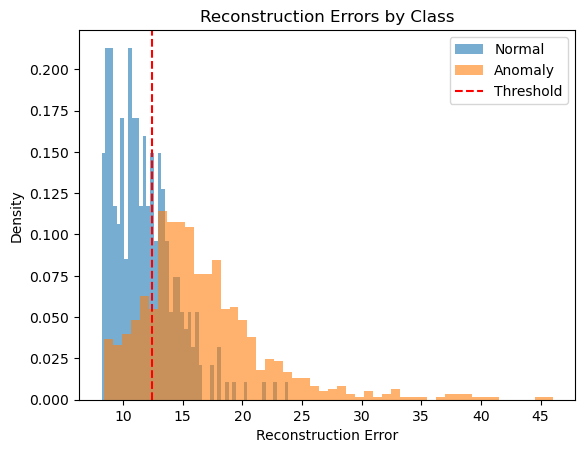

In [97]:
normal_errors = all_scores[np.array(test_labels) == 0]
anomaly_errors = all_scores[np.array(test_labels) == 1]

plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal', density=True)
plt.hist(anomaly_errors, bins=50, alpha=0.6, label='Anomaly', density=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.title("Reconstruction Errors by Class")
plt.show()


### ROC curve

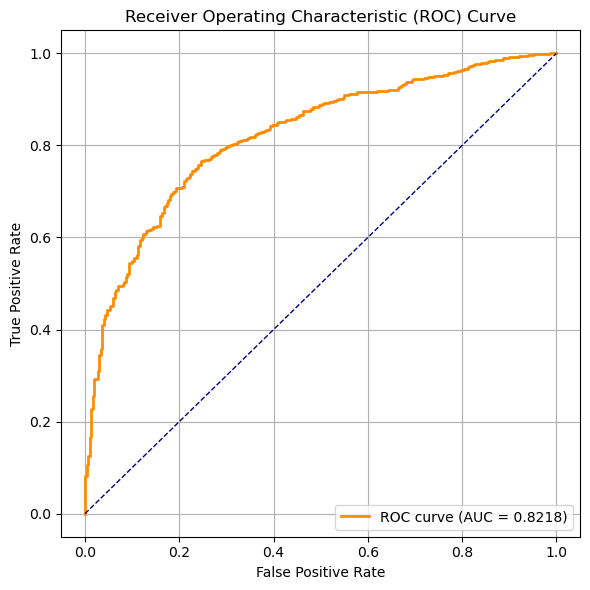

In [98]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Submission File Generation
To conform to the official scoring server, anomaly scores are collated into a header‑less CSV containing `filename` and `anomaly_score` columns. Consistent filename ordering is crucial to prevent misalignment between the submission file and the hidden evaluation labels. The function below accommodates any scoring model by injecting a callable that maps file paths to scalar scores.

In [ ]:
import pandas as pd
def write_submission(file_list, scoring_fn, out='submission.csv'):
    rows = [{'filename': f.name, 'anomaly_score': scoring_fn(f)} for f in tqdm(file_list)]
    pd.DataFrame(rows).to_csv(out, index=False, header=False)
    print('Submission saved to', out)


write_submission(
    sorted((DATA_DIR/'test').rglob('*.wav')),
    lambda f: reconstruction_error(svdd, f),
    out='submission-new.csv'
)


  0%|          | 0/1101 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1248 and 39936x128)

## Conclusion & Future Work
This notebook operationalises four complementary unsupervised anomaly‑detection paradigms, thus satisfying the methodology requirements of the AML 2025 Slide‑Rail lab. Students are encouraged to fine‑tune hyper‑parameters, integrate data augmentation, or ensemble model outputs to elevate empirical performance. Moreover, cross‑referencing the GitHub repositories may inspire nuanced architectural enhancements or novel evaluation protocols.